In [ ]:
"""
PROGETTO DI SKETCH CAPTIONING

Questo codice implementa un modello di deep learning per generare descrizioni per sketch.
Il modello utilizza una combinazione di Reti Neurali Convoluzionali (CNN) per l'estrazione delle feature delle immagini
e una LTSM per la generazione del testo.

Il codice esegue i seguenti passaggi principali:
1. Estrazione delle feature delle Immagini: Estrae le feature dalle immagini dei disegni utilizzando un modello CNN pretrained chiamata Xception.
2. Preprocessing del Testo: Pulisce il testo delle descrizioni e ne fa una tokenizzazione
3. Training del Modello: Definisce e allena un modello utilizzando le feature estratte dalle immagini e i dati di testo preprocessati.
4. Valutazione del Modello: Valuta il modello addestrato utilizzando diverse Score per valutare la qualità delle descrizioni.
5. Generazione di Caption: Genera descrizioni per nuove immagini di disegni utilizzando il modello addestrato.

Autore: Tommaso Senatori
"""

###Import Libraries and Dataset

In [ ]:
import string                    # per operazioni comuni sulle stringhe, ad esempio per rimuovere la punteggiatura dalle didascalie.
import numpy as np               # supporto per l'array multidimensionale e altre operazioni matematiche, fondamentali per il trattamento dei dati.
from PIL import Image            # per aprire, manipolare e salvare immagini, che sono dati di input per il modello di captioning.
import os                        # per interagire con il sistema operativo, ad esempio per gestire i file.
import pickle #(dump e load)     # per la serializzazione e deserializzazione di oggetti Python, utile per salvare e caricare i modelli del progetto.
import matplotlib.pyplot as plt  # per grafico loss over epochs
from tqdm.notebook import tqdm   # for seeing the progress of loops

from keras.applications.xception import Xception, preprocess_input      # Fornisce un'implementazione pre-addestrata di Xception, un modello CNN spesso utilizzato per l'estrazione delle caratteristiche delle immagini.
from keras.preprocessing.image import load_img, img_to_array            # Fornisce funzioni per caricare un'immagine da file e convertirla in un array NumPy.
from keras.preprocessing.text import Tokenizer                          # per convertire le didascalie delle immagini in sequenze di token per l'addestramento del modello.
from keras.preprocessing.sequence import pad_sequences                  # per aggiungere padding alle sequenze di token delle didascalie delle immagini, assicurando che abbiano tutte la stessa lunghezza.
from keras.utils import to_categorical, plot_model                      # per fare ohe e per stampare l'architettura dei modelli
from keras.models import Model, load_model                              # Fornisce supporto per la definizione e il caricamento dei modelli di deep learning.
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add    # Fornisce le classi necessarie per definire gli strati del modello di captioning, come strati di input, LSTM, Embedding, Dropout, ecc.
from keras.optimizers import Adam                                       # per impostare il learning rate alpha

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Tirocinio/Datasets/flickr8k_sketch"
WORKING_DIR = "/content/drive/MyDrive/Tirocinio/f8k_sketch"

dataset_text = os.path.join(BASE_DIR, 'captions.txt')
dataset_images = os.path.join(BASE_DIR, 'Images')

###Feature Extraction

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

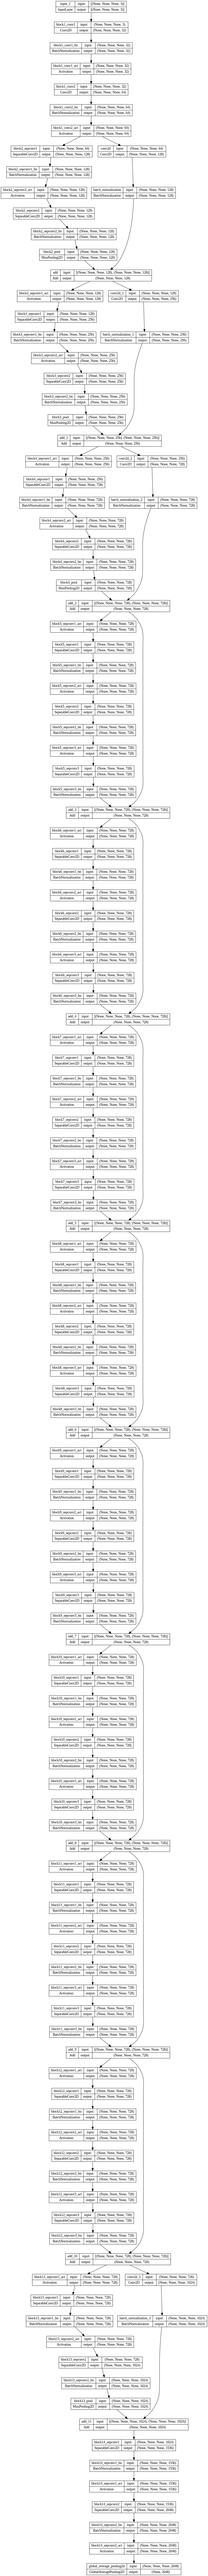

In [ ]:
model = Xception(include_top=False, pooling='avg', weights='imagenet')
# summary e plot
print(model.summary())
plot_model(model, show_shapes=True)

#  "None, None, None" shape = layer is capable of processing inputs of variable spatial dimensions.

1/1 [==============================] - 1s 1s/step
Shape of image: (1, 299, 299, 3)
Shape of extracted features: (1, 2048)


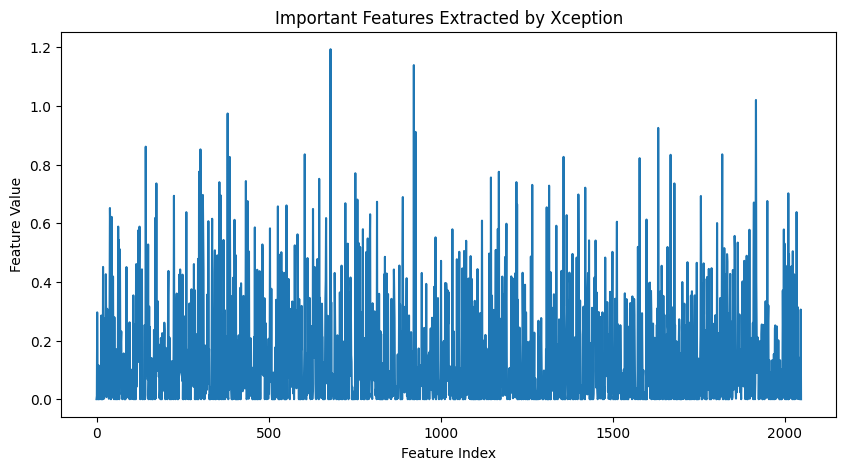

In [ ]:
img_path = dataset_images + "/69189650_6687da7280.jpg" # dog image
image = Image.open(img_path).convert('RGB')
image = image.resize((299, 299))

image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

features = model.predict(image)

print("Shape of image:", image.shape)
print("Shape of extracted features:", features.shape)

# Plotto le features più importanti
plt.figure(figsize=(10, 5))
plt.plot(features.ravel())
plt.title('Important Features Extracted by Xception')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

In [ ]:
# feature extraction dalle immagini: creo un dictionary (key,value) = (image_id,features)
def extract_features(directory):
        features = {}
        for img_name in tqdm(os.listdir(directory)): # for each image in 'Images' directory
            # load image from file
            img_path = directory + "/" + img_name
            image = Image.open(img_path)
            # reshape data for model
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            # preprocess image for Xception
            image = preprocess_input(image) # normalization e altro
            # estraggo le features
            feature = model.predict(image, verbose=0) # feature = output of the Xception
            features[img_name] = feature
        return features

# eseguo
features = extract_features(dataset_images)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# save features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_fsketch.pkl'), 'wb'))

In [ ]:
# load features from pickle
features = pickle.load(open(os.path.join(WORKING_DIR, 'features_fsketch.pkl'),"rb"))

In [ ]:
# Rimuovo estensione .jpg dalle key in features
features = {key.split('.')[0]: value for key, value in features.items()}

###Load captions data

In [ ]:
# creo un dictionary (key,value) = (image_id,captions)
def all_img_captions(filename):
    with open(filename, 'r') as file:
        captions = file.readlines()

    mapping = {}
    for line in captions[1:]:  # skip the header line
        parts = line.strip().split(',')
        img = parts[0]
        caption = ','.join(parts[1:])  # join all but the first part
        img_name = img.split('.')[0]  # tolgo estensione .jpg
        if img_name not in mapping:
            mapping[img_name] = [caption]
        else:
            mapping[img_name].append(caption)

    return mapping

In [ ]:
# eseguo
mapping = all_img_captions(dataset_text)
print("Number of unique images =" ,len(mapping))

Number of unique images = 8091


### Preprocess text data



In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')   # modelli per la tokenization
nltk.download('wordnet') # database inglese che dà correlazioni semantiche tra parole

def clean(mapping):
    lemmatizer = WordNetLemmatizer()  # Inizializzo il lemmatizer
    for key, captions in mapping.items(): # per ogni image_id e le sue 5 caption
        for i in range(len(captions)): # per ogni caption nella lista di captions
            caption = captions[i] # prendo una caption per volta

            caption = caption.lower() # lowercase
            caption = re.sub(r'[^\w\s]', '', caption) # rimuovo caratteri non alfanumerici (\w) o spazi (\s)
            caption = re.sub(r'\s+', ' ', caption) # rimpiazzo spazi consecutivi con uno solo

            # rimuovo ogni parola legata a colori dalle captions
            color_words = ['white', 'black', 'red', 'blue', 'yellow', 'green', 'orange',
                           'pink', 'grey', 'purple', 'ice', 'colorful', 'colored', 'gray',
                           'golden', 'gold', 'multicolored', 'brown', 'beige', 'tricolored']
            for word in color_words: caption = re.sub(r'\b' + word + r'\b', '', caption)

            # tokenizzo la caption in parole (token)
            tokens = word_tokenize(caption)
            # Lemmatizzazione dei token: ogni token è rimpiazzato con il suo lemma (forma base)
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
            # Rimetto il caption pulito in una stringa
            cleaned_caption = ' '.join(lemmatized_tokens)
            # Aggiungo i tag di inizio e fine
            cleaned_caption = 'startseq ' + cleaned_caption + ' endseq'
            # Sostituisco la caption originale con quella pulita
            captions[i] = cleaned_caption
    return mapping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# cleaning text
mapping = clean(mapping)
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq a child in a dress is climbing up a set of stair in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stair to her playhouse endseq',
 'startseq a little girl in a dress going into a wooden cabin endseq']

In [ ]:
# from mapping (dict) to all_captions (list)
def extract_all_captions(mapping):
    all_captions = []
    for key in mapping:
        for caption in mapping[key]:
            all_captions.append(caption)
    return all_captions

# eseguo
all_captions = extract_all_captions(mapping)

In [ ]:
len(all_captions) # 5 captions per image

40455

In [ ]:
all_captions[:10]

['startseq a child in a dress is climbing up a set of stair in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stair to her playhouse endseq',
 'startseq a little girl in a dress going into a wooden cabin endseq',
 'startseq a dog and a spotted dog are fighting endseq',
 'startseq a dog and a dog playing with each other on the road endseq',
 'startseq a dog and a dog with spot are staring at each other in the street endseq',
 'startseq two dog of different breed looking at each other on the road endseq',
 'startseq two dog on pavement moving toward each other endseq']

In [ ]:
# tokenize text (create vocabulary, assigning an index per each word)
def tokenization(all_captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

# eseguo
tokenizer = tokenization(all_captions)
vocab_size = len(tokenizer.word_index) + 1 # tot number of unique words
print(vocab_size)

7605


In [ ]:
tokenizer.word_index # the lower the integer assigned to a word, the more the frequency in the captions

{'a': 1,
 'startseq': 2,
 'endseq': 3,
 'in': 4,
 'the': 5,
 'on': 6,
 'dog': 7,
 'is': 8,
 'and': 9,
 'with': 10,
 'man': 11,
 'of': 12,
 'two': 13,
 'boy': 14,
 'girl': 15,
 'woman': 16,
 'are': 17,
 'to': 18,
 'wearing': 19,
 'at': 20,
 'people': 21,
 'water': 22,
 'child': 23,
 'young': 24,
 'an': 25,
 'his': 26,
 'running': 27,
 'through': 28,
 'playing': 29,
 'while': 30,
 'shirt': 31,
 'ball': 32,
 'down': 33,
 'standing': 34,
 'little': 35,
 'grass': 36,
 'person': 37,
 'snow': 38,
 'jumping': 39,
 'over': 40,
 'stand': 41,
 'front': 42,
 'three': 43,
 'jump': 44,
 'sitting': 45,
 'it': 46,
 'holding': 47,
 'run': 48,
 'field': 49,
 'small': 50,
 'play': 51,
 'up': 52,
 'by': 53,
 'large': 54,
 'group': 55,
 'one': 56,
 'her': 57,
 'walking': 58,
 'men': 59,
 'into': 60,
 'air': 61,
 'beach': 62,
 'mouth': 63,
 'near': 64,
 'player': 65,
 'rock': 66,
 'street': 67,
 'another': 68,
 'bike': 69,
 'for': 70,
 'from': 71,
 'riding': 72,
 'walk': 73,
 'outside': 74,
 'other': 75,
 '

In [ ]:
# get maximum length of the caption available (to do padding)
max_length = max(len(caption.split()) for caption in all_captions)
max_length

36

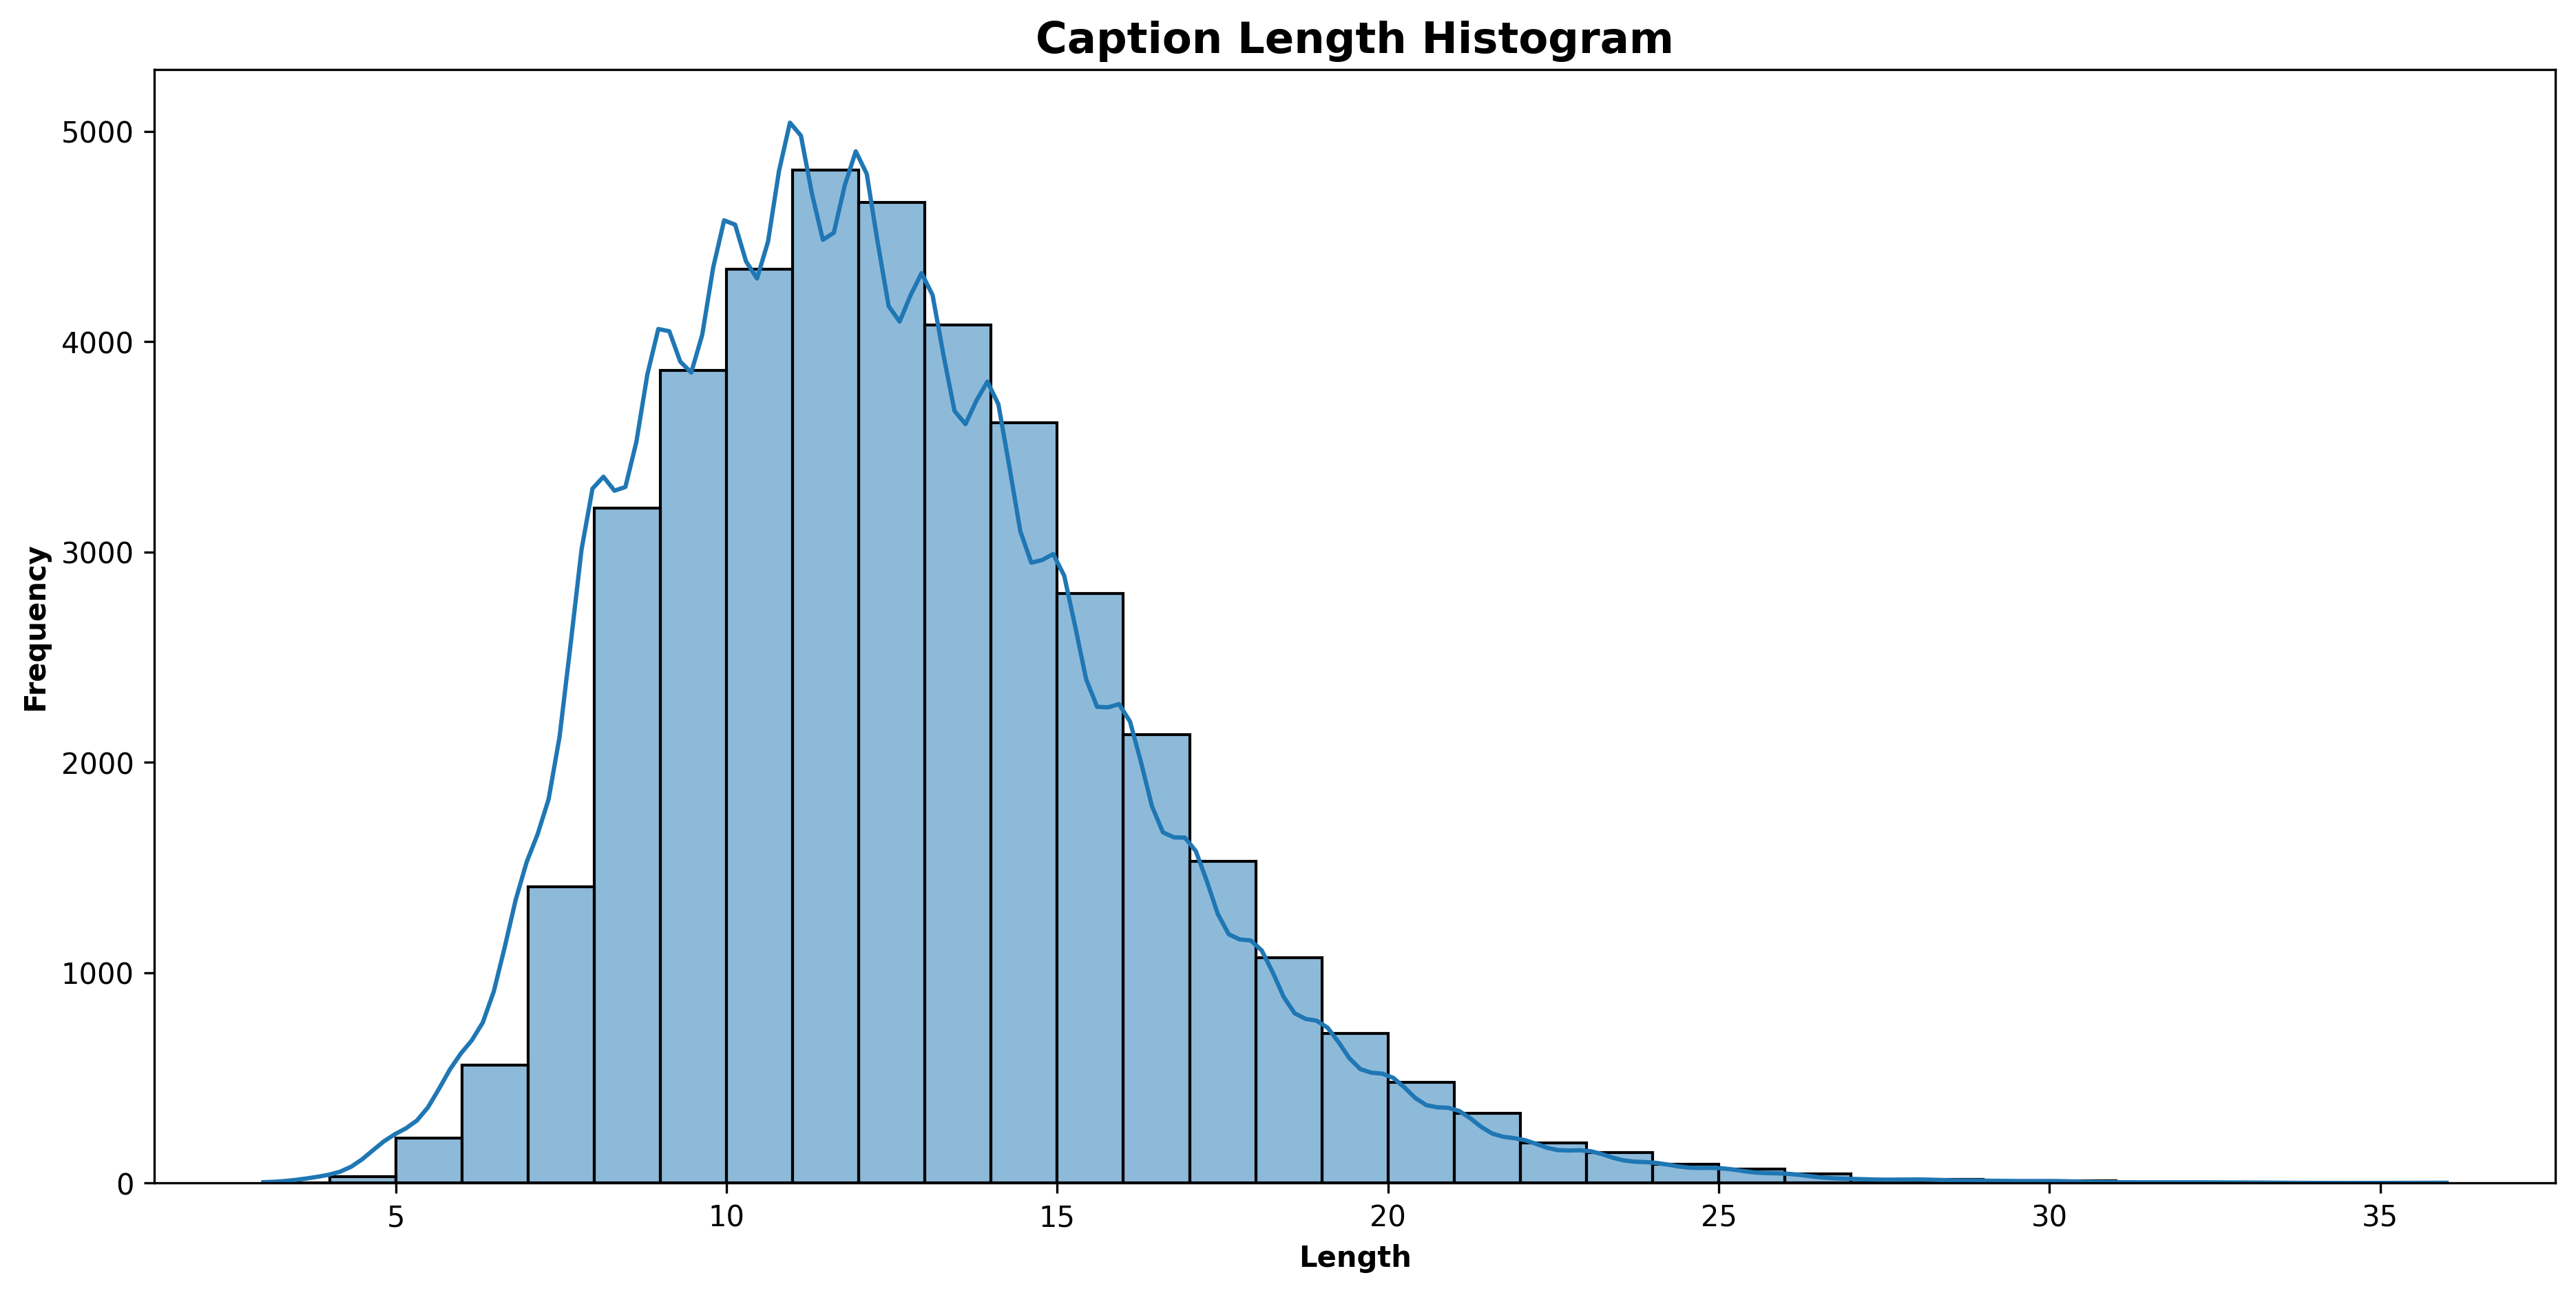

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_caption_lengths(captions):
    # dimensione e risoluzione
    plt.figure(figsize=(15, 7), dpi=300) # dotsperinch (resolution)

    # lista con length per ogni caption
    caption_lengths = [len(caption.split()) for caption in captions]

    # plot istogramma
    sns.histplot(x=caption_lengths, kde=True, binwidth=1)

    # Set plot titles and labels
    plt.title('Caption Length Histogram', fontsize=15, fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')

    # Show the plot
    plt.show()

# eseguo
plot_caption_lengths(all_captions)

###Train Test Split

In [ ]:
image_ids = list(mapping.keys())

split = int(len(image_ids) * 0.80)
train = image_ids[:split]
remaining = image_ids[split:]

# Divido le immagini restanti a metà tra validation set e test set
split2 = len(remaining) // 2
val = remaining[:split2]
test = remaining[split2:]

# Verify the sizes of the splits
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Train set size: 6472
Validation set size: 809
Test set size: 810


In [ ]:
# creo data generator per dividire i dati in batch (evita il session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list() #((3746, 2048), (3746, 36), (3746, 7605))
    n = 0
    while 1:
        for key in data_keys: # for each image_id
            n+=1
            captions = mapping[key]
            # processo ogni caption
            for caption in captions: # per ogni caption con lo stesso image_id
                # encode the sequence: we get an index for each word
                seq = tokenizer.texts_to_sequences([caption])[0]
                # splitto la sequenza in coppie X,y
                for i in range(1, len(seq)):
                    # split into input and output paths
                    in_seq, out_seq = seq[:i], seq[i]
                    # padding of input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # one hot encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size: # reset per evitare un crash
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# You can check the shape of the input and output for your model

gen = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size=64)

# Get a batch of data from the generator
X, y = next(gen)

# Print the shape of X1, X2, and y
X1, X2 = X
print("Shape of X1:", X1.shape) # trainingset_size, features of feature vector
print("Shape of X2:", X2.shape) # trainingset_size, max_length
print("Shape of y:", y.shape) # trainingset_size, vocab_size

Shape of X1: (3746, 2048)
Shape of X2: (3746, 36)
Shape of y: (3746, 7605)


###Model Creation

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length, alpha):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,)) # input: Xception output (2048)
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha))

    return model

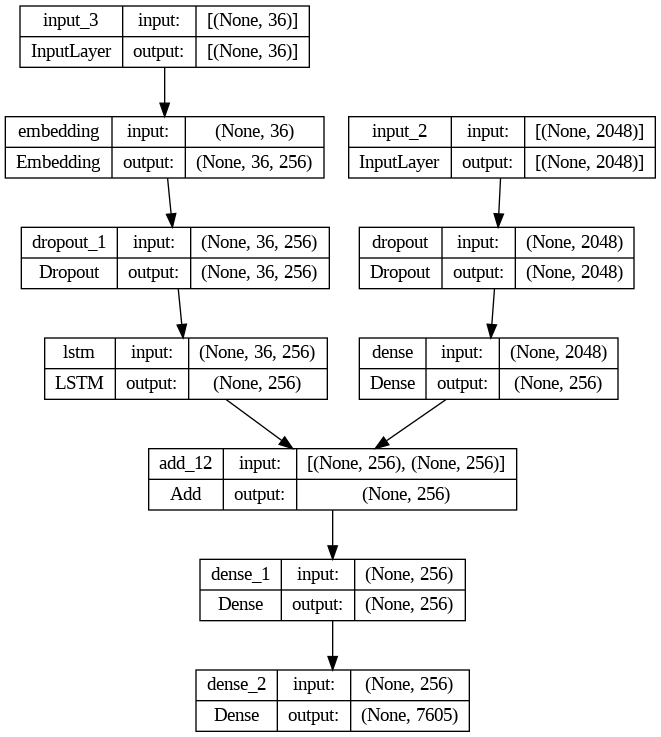

In [ ]:
model = define_model(vocab_size, max_length, alpha=0.001)
plot_model(model, show_shapes=True)

###Train the model

In [ ]:
losses = []
val_losses = []
epochs = 10
batch_size = 64
steps = len(train) // batch_size
val_steps = len(val) // batch_size

for i in range(epochs):
    # Create data generator for training set
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Create data generator for validation set
    val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Fit the model for 1 epoch
    history = model.fit(train_generator, epochs=1, steps_per_epoch=steps, validation_data=val_generator,
                        validation_steps=val_steps, verbose=1)

    # Store the losses for this epoch
    losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])

    # Save the model at the 7th epoch
    if i == 6: model.save(WORKING_DIR + '/MODEL_7FSKETCH.h5')

101/101 [==============================] - 48s 477ms/step - loss: 2.9079 - val_loss: 3.3376


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 47s 467ms/step - loss: 2.6673 - val_loss: 3.3384


In [ ]:
# Load the pre-trained model
model = load_model(WORKING_DIR + '/MODEL_10FSKETCH.h5')

# Load the pre-saved losses
with open(os.path.join(WORKING_DIR, 'losses_10fsketch.pkl'), 'rb') as f:
    losses = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'vlosses_10fsketch.pkl'), 'rb') as f:
    val_losses = pickle.load(f)

epochs = 5
batch_size = 64
steps = len(train) // batch_size
val_steps = len(val) // batch_size

for i in range(epochs):
    # Create data generator for training set
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Create data generator for validation set
    val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Fit the model for 1 epoch
    history = model.fit(train_generator, epochs=1, steps_per_epoch=steps, validation_data=val_generator,
                        validation_steps=val_steps, verbose=1)

    # Store the losses for this epoch
    losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])

    # Save the model at the 12th epoch
    if i == 1: model.save(WORKING_DIR + '/MODEL_12FSKETCH.h5')

101/101 [==============================] - 47s 466ms/step - loss: 2.5430 - val_loss: 3.3666


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 47s 469ms/step - loss: 2.3929 - val_loss: 3.3886


In [ ]:
# Save losses
with open(os.path.join(WORKING_DIR, 'losses_15fsketch.pkl'), 'wb') as f:
    pickle.dump(losses, f)
with open(os.path.join(WORKING_DIR, 'vlosses_15fsketch.pkl'), 'wb') as f:
    pickle.dump(val_losses, f)

In [ ]:
# Load losses
with open(os.path.join(WORKING_DIR, 'losses_15fsketch.pkl'), 'rb') as f:
    losses = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'vlosses_15fsketch.pkl'), 'rb') as f:
    val_losses = pickle.load(f)

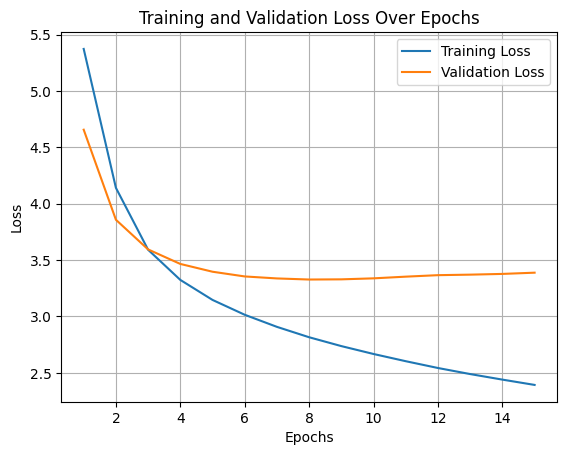

In [ ]:
def plot_loss(losses, val_losses):
    epochs = len(losses)
    plt.plot(range(1, epochs + 1), losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(losses, val_losses)


In [ ]:
# save the model
model.save(WORKING_DIR + '/MODEL_10FSKETCH.h5')

In [ ]:
# load the model
model = load_model(WORKING_DIR + '/MODEL_7FSKETCH.h5')

###Generate captions for the image

In [ ]:
def idx_to_word(integer, tokenizer): # rida la parola a cui corrisponde l'integer
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generazione della caption per un'immagine (greedy)
def predict_caption_greedy(model, image_features, tokenizer, max_length):
    # aggiungo lo start tag
    in_text = 'startseq'
    # per ogni parola (caption non più lunga di max_length)
    for i in range(max_length):
        # encode input sequence (convert words to integers)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict the next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # get index with highest probability
        yhat = np.argmax(yhat)
        # convert predicted index to a word
        word = idx_to_word(yhat, tokenizer)
        # stop if word is not found
        if word is None: break
        # else : append word as input for generating next word
        in_text += " " + word
        # stop se raggiungiamo l'end tag
        if word == 'endseq': break
    return in_text

In [ ]:
# generazione della caption per un'immagine (beam search)
def predict_caption_beam_search(model, image_features, tokenizer, max_length, beam_width):
    # Inizializzazione
    start_seq = 'startseq'
    sequences = [(start_seq, 0.0)] # (word, LogLikelihood)

    # Beam search loop
    while len(sequences[0][0].split()) < max_length:
        all_candidates = []
        # iteriamo per ogni elemento in ogni sequenza
        for seq, score in sequences:
            # Encode input sequence
            encoded_seq = tokenizer.texts_to_sequences([seq])[0]
            # pad the sequence
            encoded_seq = pad_sequences([encoded_seq], maxlen=max_length, padding='post')
            # get probabilities of every word to be the next
            yhat = model.predict([image_features, encoded_seq], verbose=0)
            # Get top "beam_width" candidates
            top_candidates = np.argsort(yhat[0])[-beam_width:] # [-x:] : gli ultimi 3 (i più alti)
            # per ogni candidate, creo una nuova sequenza
            for word_idx in top_candidates:
                candidate_seq = seq + " " + idx_to_word(word_idx, tokenizer)   # aggiungo la parola alla sequenza
                candidate_score = score + np.log(yhat[0][word_idx])
                all_candidates.append((candidate_seq, candidate_score)) # calcolo la score della parola
        # ordino tutti i candidates in base al loro 2o elemento (score)
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        # seleziono i primi "beam_width" candidates
        sequences = ordered[:beam_width]
        # stop se raggiungiamo l'end tag
        if sequences[0][0].split()[-1] == 'endseq': break

    # return best sequence
    return sequences[0][0]

beam_width = 5

###Calculate BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione greedy
def calculate_bleu_score_greedy(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual 5 captions
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_greedy(model, features[key], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the lists
        actual.append(actual_captions)
        predicted.append(y_pred)

    # calculate BLEU score (score for text data) (excellent if >0.4)
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    return bleu1, bleu2


# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione beam search
def calculate_bleu_score_beam_search(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual 5 captions
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the lists
        actual.append(actual_captions)
        predicted.append(y_pred)

    # calculate BLEU score (score for text data) (excellent if >0.4)
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    return bleu1, bleu2


# eseguo

bleu1_greedy, bleu2_greedy = calculate_bleu_score_greedy(model, test, mapping, features, tokenizer, max_length)
print("BLEU-1 (greedy): {:.6f}".format(bleu1_greedy))
print("BLEU-2 (greedy): {:.6f}".format(bleu2_greedy))

bleu1_beam, bleu2_beam = calculate_bleu_score_beam_search(model, test, mapping, features, tokenizer, max_length)
print("BLEU-1 (beam search): {:.6f}".format(bleu1_beam))
print("BLEU-2 (beam search): {:.6f}".format(bleu2_beam))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 (greedy): 0.637837
BLEU-2 (greedy): 0.435486


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 (beam search): 0.641945
BLEU-2 (beam search): 0.443784


In [ ]:
# SEGNATI LE SCORE

# epochs = 7 --> 3.3376, 0.637837, 0.435486 (greedy)
# epochs = 7 --> 3.3376, 0.641945, 0.443784 (beam search)

# epochs = 10 --> 3.3384, 0.597270, 0.404826 (greedy)
# epochs = 12 --> 3.3666, 0.547894, 0.372122 (greedy)

###Calculate CIDEr Score

In [ ]:
from pycocoevalcap.cider.cider import Cider

# Calcola la score CIDEr per l'intero test set, usando il metodo di predizione greedy
def calculate_cider_score_greedy(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = {}, {} # devono per forza essere mappe, perchè sono i parametri di compute_score

    for key in tqdm(test):  # for each image_id in test set
        # get actual 5 captions
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_greedy(model, features[key], tokenizer, max_length)
        # append to the dictionaries
        actual[key] = [' '.join(caption.split()) for caption in captions]
        predicted[key] = [' '.join(y_pred.split())]

    # calculate CIDEr score
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)

    return cider_score


# Calcola la score CIDEr per l'intero test set, usando il metodo di predizione beam search
def calculate_cider_score_beam_search(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = {}, {} # devono per forza essere mappe, perchè sono i parametri di compute_score

    for key in tqdm(test):  # for each image_id in test set
        # get actual 5 captions
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width)
        # append to the dictionaries
        actual[key] = [' '.join(caption.split()) for caption in captions]
        predicted[key] = [' '.join(y_pred.split())]

    # calculate CIDEr score
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)

    return cider_score


# eseguo

cider_score_greedy = calculate_cider_score_greedy(model, test, mapping, features, tokenizer, max_length)
print("CIDEr (greedy): {:.6f}".format(cider_score_greedy))

cider_score_beam_search = calculate_cider_score_beam_search(model, test, mapping, features, tokenizer, max_length)
print("CIDEr (beam search): {:.6f}".format(cider_score_beam_search))

  0%|          | 0/810 [00:00<?, ?it/s]

CIDEr (greedy): 0.344474


  0%|          | 0/810 [00:00<?, ?it/s]

CIDEr (beam search): 0.401337


###Calculate ROUGE-L Score

In [ ]:
from rouge import Rouge

# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione greedy
def calculate_rougel_score_greedy(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual 5 captions
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_greedy(model, features[key], tokenizer, max_length)
        # append to the lists
        actual.extend(captions)
        predicted.extend([y_pred] * 5) # ho 1 caption generata per ogni 5 caption effettive

    # calculate ROUGE-L score
    rouge = Rouge()
    scores = rouge.get_scores(predicted, actual, avg=True)
    rouge_l_score = scores["rouge-l"]["f"] #ROUGE-L, F1-score

    return rouge_l_score


# Calcola le score BLEU-1 e BLEU-2 per l'intero test set, usando il metodo di predizione beam search
def calculate_rougel_score_beam_search(model, test, mapping, features, tokenizer, max_length):
    actual, predicted = list(), list()

    for key in tqdm(test):  # for each image_id in test set
        # get actual 5 captions
        captions = mapping[key]
        # predict the entire caption for image
        y_pred = predict_caption_beam_search(model, features[key], tokenizer, max_length, beam_width)
        # append to the lists
        actual.extend(captions)
        predicted.extend([y_pred] * 5) # ho 1 caption generata per ogni 5 caption effettive

    # calculate ROUGE-L score
    rouge = Rouge()
    scores = rouge.get_scores(predicted, actual, avg=True)
    rouge_l_score = scores["rouge-l"]["f"] #ROUGE-L, F1-score

    return rouge_l_score


# eseguo

rougel_greedy = calculate_rougel_score_greedy(model, test, mapping, features, tokenizer, max_length)
print("ROUGE-L (greedy): {:.6f}".format(rougel_greedy))
rougel_beam_search = calculate_rougel_score_beam_search(model, test, mapping, features, tokenizer, max_length)
print("ROUGE-L (beam search): {:.6f}".format(rougel_beam_search))

  0%|          | 0/810 [00:00<?, ?it/s]

ROUGE-L (greedy): 0.412261


  0%|          | 0/810 [00:00<?, ?it/s]

ROUGE-L (beam search): 0.417325


###Visualize the results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    print('---------------------Actual---------------------')
    captions = mapping[image_id]
    for caption in captions:
        print(caption)

    print('---------------------Predicted (Greedy)---------------------')
    y_pred_greedy = predict_caption_greedy(model, features[image_id], tokenizer, max_length)
    print(y_pred_greedy)

    print('---------------------Predicted (Beam Search)---------------------')
    y_pred_beam_search = predict_caption_beam_search(model, features[image_id], tokenizer, max_length, beam_width)
    print(y_pred_beam_search)

    plt.imshow(image)


####Training Images

---------------------Actual---------------------
startseq a man jump high on his skateboard over the concrete tile endseq
startseq a skateboarder get airtime endseq
startseq a skateboarder jumping with his skateboard endseq
startseq boy jumping in the air with a skateboard endseq
startseq skateboarder in with skateboard in midair endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a shirt is jumping a skateboard on a track endseq
---------------------Predicted (Beam Search)---------------------
startseq a man in a shirt and pant is doing a trick on a skateboard endseq


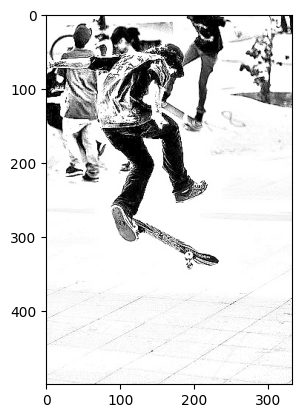

In [ ]:
generate_caption("3212465975_b657f40eed.jpg") #beam

---------------------Actual---------------------
startseq a dog and a dog are jumping up to catch a toy endseq
startseq a dog and a dog play with a toy on a courtyard endseq
startseq a and lab are outside and the lab is catching a toy in it mouth endseq
startseq dog snap at and object a dog lunge endseq
startseq the chocolate lab jump too late to get the toy a the lab capture it in the driveway endseq
---------------------Predicted (Greedy)---------------------
startseq a dog is running on a dirt path endseq
---------------------Predicted (Beam Search)---------------------
startseq two dog are playing in the grass endseq


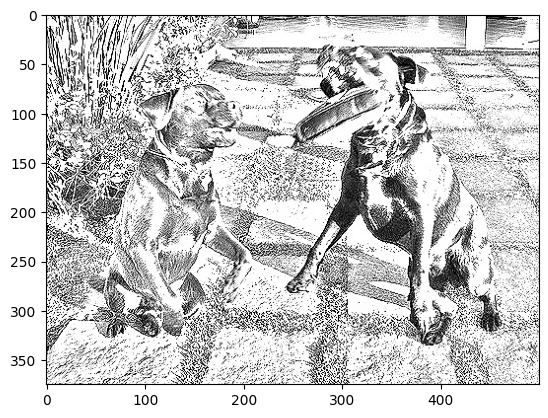

In [ ]:
generate_caption("1030985833_b0902ea560.jpg") #beam

---------------------Actual---------------------
startseq a boy wearing a shirt and jean is doing a flip on his bike endseq
startseq a person flipping a bicycle upside down endseq
startseq a person flip on a bike endseq
startseq a person in a shirt doing trick on a bicycle endseq
startseq a person is show upside down on his bicycle over a large field endseq
---------------------Predicted (Greedy)---------------------
startseq a man is jumping on a bike in midair endseq
---------------------Predicted (Beam Search)---------------------
startseq a man is doing a trick on a bike in midair endseq


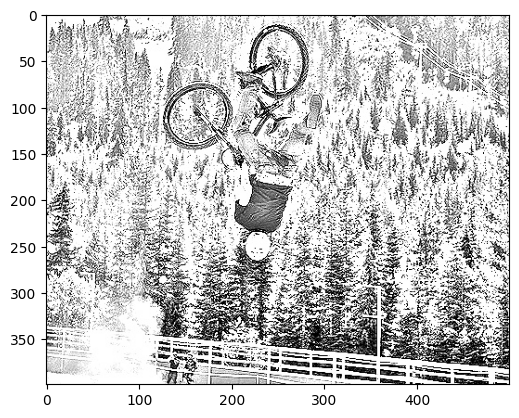

In [ ]:
generate_caption("55135290_9bed5c4ca3.jpg") #ok

---------------------Actual---------------------
startseq a climber wearing a helmet and headlamp is attached to a rope on the rock face endseq
startseq a man climb a rocky wall endseq
startseq a rock climber climb a large rock endseq
startseq a woman in snakeskin pant climb a rock endseq
startseq person with helmet and pant is rock climbing endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a shirt is climbing a rock endseq
---------------------Predicted (Beam Search)---------------------
startseq a man in a shirt is climbing a rock endseq endseq


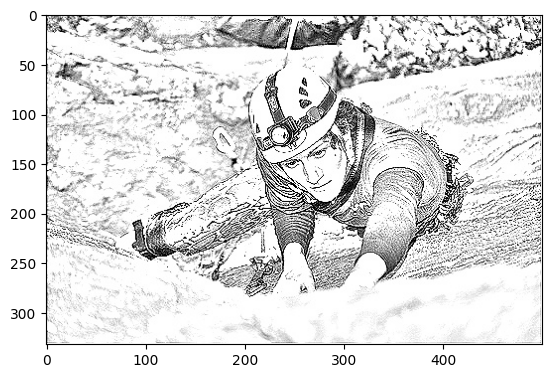

In [ ]:
generate_caption("111537222_07e56d5a30.jpg")

---------------------Actual---------------------
startseq a competitive motorcycle racer prepares to make a left turn along a paved road endseq
startseq a man ride a motorcycle with the number 5 on it endseq
startseq a motorcycle driver swerve to the left endseq
startseq a motorcycle with number five on front is being ridden by a rider wearing a helmet endseq
startseq professional motorcycle racer turning a corner endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a helmet is riding a motorcycle endseq
---------------------Predicted (Beam Search)---------------------
startseq a man in a helmet is riding a motorcycle endseq


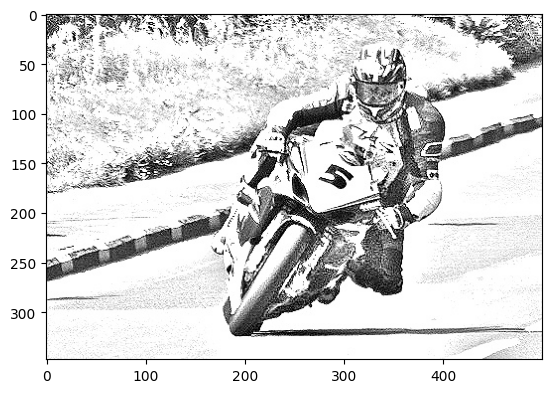

In [ ]:
generate_caption("161669933_3e7d8c7e2c.jpg") #ok

####Test Images

---------------------Actual---------------------
startseq a dog jumping into a lake endseq
startseq a dog with a collar is jumping in the water endseq
startseq a dog with a collar is jumping out of the water endseq
startseq dog with collar splashing in water endseq
startseq the dog with a collar is jumping through the water endseq
---------------------Predicted (Greedy)---------------------
startseq a dog is running through water endseq
---------------------Predicted (Beam Search)---------------------
startseq a dog swimming in water endseq


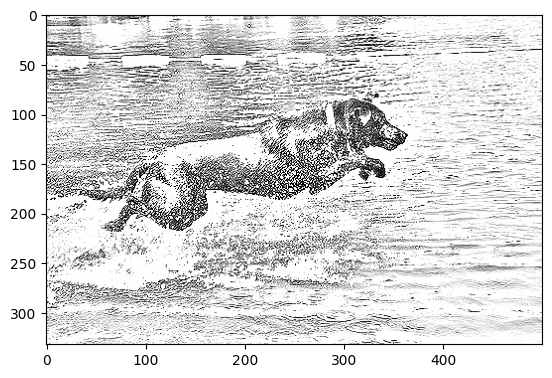

In [ ]:
generate_caption("3710520638_866d542a80.jpg") #ok

---------------------Actual---------------------
startseq a man on a motorcycle touch his knee to the ground during a sharp turn endseq
startseq a motorcycle racer riding a motorcycle endseq
startseq a person on a motorcycle endseq
startseq a motorcycle and rider take a turn endseq
startseq the motorcycle rider in and is making a turn endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a helmet is riding a motorcycle endseq
---------------------Predicted (Beam Search)---------------------
startseq a man in a helmet is riding a motorcycle endseq


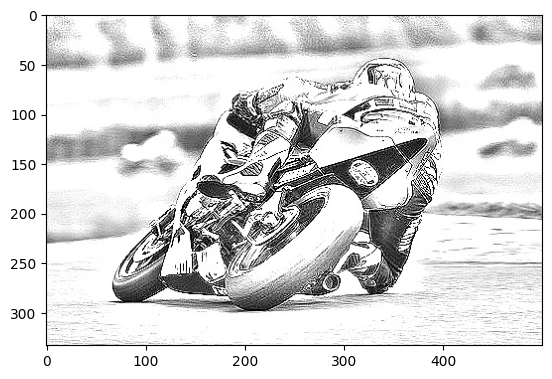

In [ ]:
generate_caption("3564148252_aa4cb36a32.jpg") #ok

---------------------Actual---------------------
startseq a person holding a tennis racket hit a tennis ball endseq
startseq a tennis player hitting the ball endseq
startseq a tennis player hitting the ball endseq
startseq the tennis ball is about to be hit endseq
startseq this man is hitting a tennis ball with a tennis racket endseq
---------------------Predicted (Greedy)---------------------
startseq a tennis player in a shirt is hitting a tennis ball endseq
---------------------Predicted (Beam Search)---------------------
startseq a tennis player hitting a tennis ball endseq


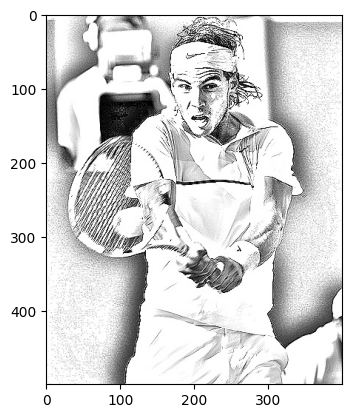

In [ ]:
generate_caption("3425887426_bf60b8afa3.jpg") #ok

---------------------Actual---------------------
startseq a guy in a shirt with a bike get very high in the air endseq
startseq a man in midair holding his bike s handlebar endseq
startseq a man is performing a trick high in the air with a bicycle endseq
startseq a man wearing a shirt is doing a trick high in the air with his bike endseq
startseq man holding onto bike handlebar while in midair endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a helmet is riding a bike on a dirt bike endseq
---------------------Predicted (Beam Search)---------------------
startseq a man in a helmet is riding a bike in the air endseq


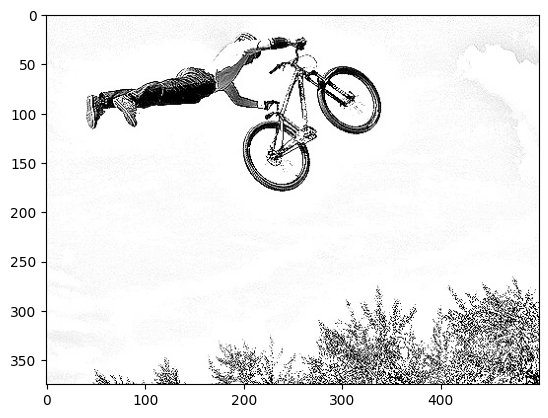

In [ ]:
generate_caption("2520909293_9bb7f7364e.jpg") #beam

---------------------Actual---------------------
startseq a dog chase another dog who ha a ball endseq
startseq two dog are running in the grass one ha a ball in his mouth endseq
startseq two dog are playing with a toy on grass endseq
startseq two dog run through a field endseq
startseq two dog run together endseq
---------------------Predicted (Greedy)---------------------
startseq a dog is running on a grassy field endseq
---------------------Predicted (Beam Search)---------------------
startseq two dog are playing in the grass endseq


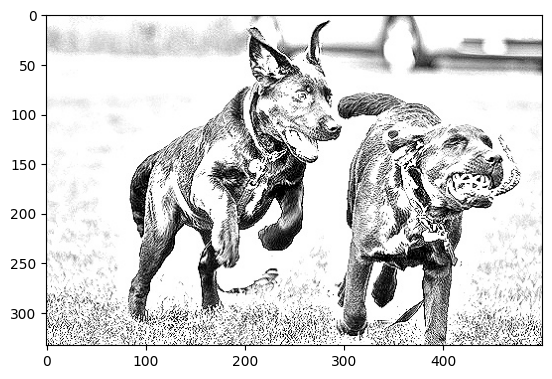

In [ ]:
generate_caption("3626998066_3ae11ee278.jpg") #beam

---------------------Actual---------------------
startseq a dog jump over another dog a both animal are trying to catch the same ball endseq
startseq two and dog playing with a ball endseq
startseq two dog playing one dog is jumping in the air above the second dog endseq
startseq two terrier jumping after a tennis ball in a park endseq
startseq two and dog play and jump in a fenced area endseq
---------------------Predicted (Greedy)---------------------
startseq a dog is running on a grassy field endseq
---------------------Predicted (Beam Search)---------------------
startseq two dog play in the grass endseq


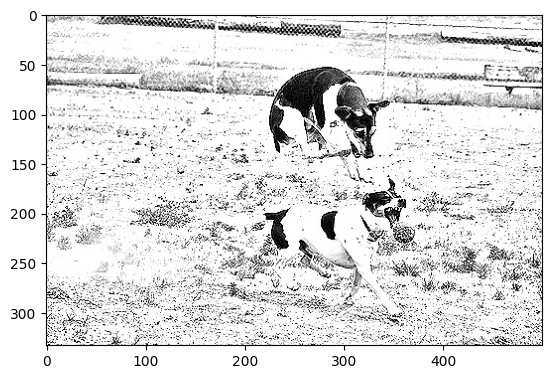

In [ ]:
generate_caption("3627216820_4952bacbcb.jpg") #beam

---------------------Actual---------------------
startseq a blond girl ride the wave endseq
startseq a person in a wetsuit is surfing a small wave on a surfboard endseq
startseq a woman is attempting to ride a small wave endseq
startseq person surfboard on a wave endseq
startseq the lady is surfing and riding a wave endseq
---------------------Predicted (Greedy)---------------------
startseq a surfer is surfing in the ocean endseq
---------------------Predicted (Beam Search)---------------------
startseq a surfer surfing in the ocean endseq endseq


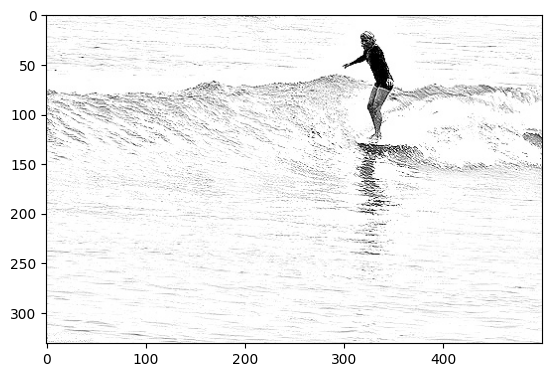

In [ ]:
generate_caption("3627679667_0e3de9fc90.jpg") #ok

---------------------Actual---------------------
startseq a person jumping high above their skateboard on the street endseq
startseq a skateboarder fly through the air endseq
startseq a young man is caught in midair while doing a skateboard trick in an urban environment endseq
startseq skateboarder jumping in air and his skateboard is between his leg endseq
startseq the skateboard is falling away from the skateboarder a he attempt a jump endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a shirt is skateboarding on a skateboard endseq
---------------------Predicted (Beam Search)---------------------
startseq a man is doing a trick on a skateboard endseq


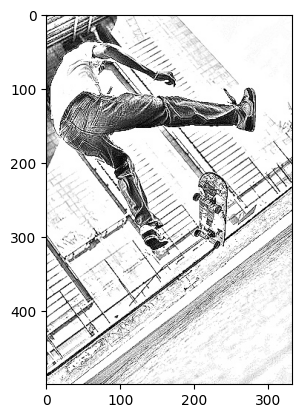

In [ ]:
generate_caption("3523972229_d44e9ff6d7.jpg") #ok

---------------------Actual---------------------
startseq a biker performs a trick in the air endseq
startseq a child ride a bike high in the air endseq
startseq a person flying through the air on a bicycle endseq
startseq a person is jumping while riding a bike endseq
startseq a person on a bike fly through the air with the sun flaring through the bike frame endseq
---------------------Predicted (Greedy)---------------------
startseq a man is performing a trick on a bike endseq
---------------------Predicted (Beam Search)---------------------
startseq a man is performing a trick on a bike endseq


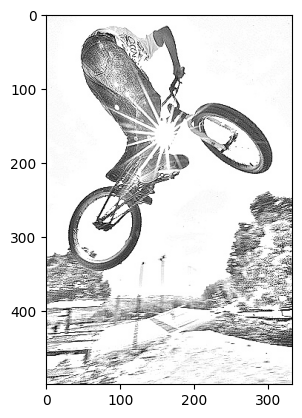

In [ ]:
generate_caption("3522076584_7c603d2ac5.jpg") #ok

---------------------Actual---------------------
startseq a man ski on a snowy mountain endseq
startseq a person ski down a steep snowy hill endseq
startseq a skier skiing down a snowy mountainside endseq
startseq a skier speed through the snow endseq
startseq the skier is descending the hill whilst wearing a silver helmet and backpack endseq
---------------------Predicted (Greedy)---------------------
startseq a person in a jacket is skiing down a snowy mountain endseq
---------------------Predicted (Beam Search)---------------------
startseq a person skiing down a snowy mountain endseq


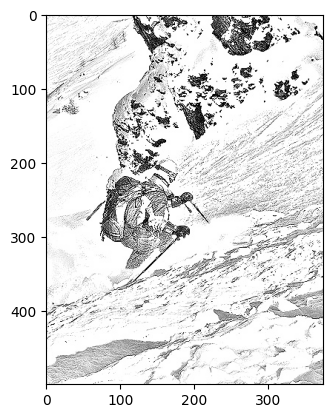

In [ ]:
generate_caption("511844627_0ec78e01e9.jpg") #greedy

---------------------Actual---------------------
startseq a dog playing with a toy in the snow endseq
startseq a dog run through the snow carrying a toy endseq
startseq a dog play in the snow endseq
startseq dog running with a toy in the snowy field endseq
startseq the and dog carry a toy in the snow endseq
---------------------Predicted (Greedy)---------------------
startseq a dog running through the snow endseq
---------------------Predicted (Beam Search)---------------------
startseq a dog running in the snow endseq


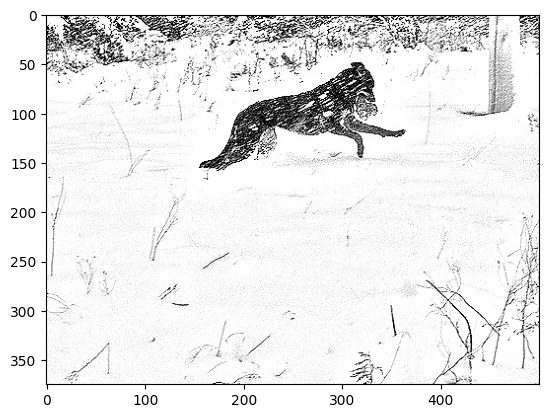

In [ ]:
generate_caption("447800028_0242008fa3.jpg") #ok

---------------------Actual---------------------
startseq a boy jump into the water upside down endseq
startseq a child diving headfirst into a lake endseq
startseq a man is falling backward in swim gear over a large body of water nearby an urban area endseq
startseq the man is going into the water endseq
startseq the person is going into the water endseq
---------------------Predicted (Greedy)---------------------
startseq a man in a wetsuit is jumping into the air endseq
---------------------Predicted (Beam Search)---------------------
startseq a man in a wetsuit is jumping into the water endseq


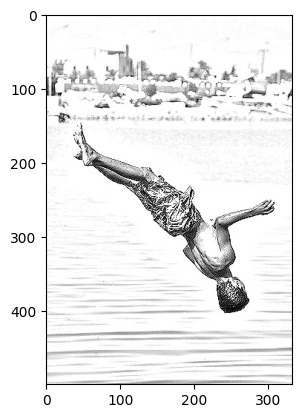

In [ ]:
generate_caption("3667492609_97f88b373f.jpg") #meh